In [1]:
using Gillespie
using Plots
using LinearAlgebra
using StatsBase

In [2]:
"""
    vectorize(x)

Vectorizes an operator.

# Arguments
- `x`: operator to be vectorized

# Returns
- the vectorized form of `x`
"""
function vectorize(x)
    return vec(x)
end

"""
    unvectorize(x)

Translates a vectorized operator into the matrix form.

# Arguments
- `x`; operator in vectorized form

# Returns
- the operator in matrix form
"""
function unvectorize(x)
    # Assumes the input object to be a reshapable to a square matrix.
    d = trunc(Int, sqrt(length(x)))
    return reshape(x, (d,d))
end

"""
    gillespie_partial_monitoring(
        H::Matrix{ComplexF64},
        M_l::Vector{Matrix{ComplexF64}},
        S_l::Vector{Matrix{ComplexF64}},
        ρ0::Matrix{ComplexF64},
        t_final::Float64,
        dt::Float64,
        number_trajectories::Int64,
        verbose::Bool=false)

Gillespie-based simulation with partial monitoring, and allowing for mixed initial states.

# Arguments
- `H`: Hamiltonian matrix
- `M_l`: list of monitored jump operators
- `S_l`: list of un-monitored jump operators
- `ρ0`: initial state of the system
- `t_final`: final time of the evolution
- `dt`: time increment considered
- `number_trajectories`: number of trajectories of the simulation
- `verbose`: if true, gives more output. Verbose=true for large simulations can fill up completely the text buffer and cause a crash

# Returns
- `trajectories_results`: list of dictionaries with each jump channel, times and states after jumps
- `V`: list of pre-computed no-jump non-Hermitian evolution operators
- `t_range`: range of times at which the V operators are computed
"""
function gillespie_partial_monitoring(
    H::Matrix{ComplexF64},
    M_l::Vector{Matrix{ComplexF64}},
    S_l::Vector{Matrix{ComplexF64}},
    ρ0::Matrix{ComplexF64},
    t_final::Float64,
    dt::Float64,
    number_trajectories::Int64,
    verbose::Bool=false)

    println("Starting Gillespie from function")

    # Range of times.
    t_range = 0.:dt:t_final

    # M_l is the list of jumps corresponding to monitored channels.
    # S_l is the list of jumps corresponding to un-monitored channels.

    # Creates the appropriate identity matrix.
    d = size(H)[1]
    ide = Matrix{Float64}(I, d, d)

    # Creates the J operator.
    J = zero(ide)
    # Cycle over the monitored operators.
    for M in M_l
        J += M' * M
    end

    # Vectorized version of J.
    vect_J = vectorize(J)

    # Vectorized form of L_0.
    # Hamiltonian part.
    vect_L0 = -1im * kron(ide, H) + 1im * kron(transpose(H), ide)
    # Cycle over the un-monitored operators.

    println("Completed until S_l appears")

    for S in S_l
        vect_L0 += kron(conj.(S), S) - 0.5 * kron(ide, S' * S) - 0.5 * kron(transpose(S' * S), ide)
    end
    # Cycle over the monitored operators.
    for M in M_l
        vect_L0 += - 0.5 * kron(ide, M' * M) - 0.5 * kron(transpose(M' * M), ide)
    end

    println("Completed until monitored operators")
    
    # Vectorized form of L_0^\dagger.
    # Hamiltonian part.
    vect_L0_dagger = 1im * kron(ide, H) - 1im * kron(transpose(H), ide)
    # Cycle over the un-monitored operators.
    for S in S_l
        vect_L0_dagger += kron(transpose(S), S') - 0.5 * kron(transpose(S' * S), ide) - 0.5 * kron(ide, S' * S)
    end
    # Cycle over the monitored operators.
    for M in M_l
        vect_L0_dagger += - 0.5 * kron(transpose(M' * M), ide) - 0.5 * kron(ide, M' * M)
    end

    # Pre-computation stage.
    # Creates the list of the no-jump evolution operators and the non-state dependent part of the waiting time distribution.
    V = Matrix{ComplexF64}[] 
    Qs = Matrix{ComplexF64}[]
    for t in t_range
        ev_op = exp(vect_L0 * t)
        push!(V, ev_op)
        nsd_wtd = unvectorize(exp(vect_L0_dagger * t) * vect_J)
        push!(Qs, nsd_wtd)
    end

    println("Completed precomputation")

    # TODO: Some way of quantifying the error (like the norm of the latest Qs in the normal version)

    # Vector for the results of the computation.
    trajectories_results = Array{Dict{String, Any}}[]

    # Cycle over the trajectories.
    for trajectory in 1:number_trajectories
        # Initial state.
        ρ = ρ0
        # Absolute time.
        τ = 0

        # Creates the array of results for the single trajectory, and pushes the initial state as a fictitious fist jump.
        results = Dict{String, Any}[]
        dict_initial = Dict("AbsTime" => 0,
            "TimeSinceLast" => 0,
            "JumpChannel" => nothing,
            "ρAfter" => ρ0)
        push!(results, dict_initial)

        while τ < t_final 
            dict_jump = Dict()

            # Compute the waiting time distribution, exploiting the pre-computed part.
            Ps = Float64[]
            for Q in Qs
                wtd =  real(tr(Q * ρ))
                push!(Ps, wtd)
            end

            # Sample from the waiting time distribution.
            n_T = sample(1:length(t_range), Weights(Ps))

            # Increase the absolute time.
            τ += t_range[n_T]
            merge!(dict_jump, Dict("AbsTime" => τ, "TimeSinceLast" => t_range[n_T]))

            # Update the state.
            vect_ρ = V[n_T] * vectorize(ρ)
            ρ = unvectorize(vect_ρ)
            # Chooses where to jump.
            weights = Float64[]
            for M in M_l
                weight = real(tr(M' * M * ρ))
                push!(weights, weight)
            end
            n_jump = sample(1:length(M_l), Weights(weights))
            merge!(dict_jump, Dict("JumpChannel" => n_jump))
            # Update the state after the jump.
            ρ = M_l[n_jump] * ρ * (M_l[n_jump])'
            norm_state = real(tr(ρ))
            # Renormalize the state.
            ρ = ρ / norm_state
            merge!(dict_jump, Dict("ρAfter" => ρ))

            if verbose
                println(string(dict_jump))
            end

            push!(results, dict_jump)
        end

        push!(trajectories_results, results)
    end

    return trajectories_results, V, t_range
end

function state_at_time_on_trajectory_mixed(
    t_range::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
    relevant_times::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
    V::Vector{Matrix{ComplexF64}},
    trajectory_data::Vector{Dict{String, Any}})

    # Creates an array of states.
    v_states = Matrix{ComplexF64}[]

    # Creates an array of jump times.
    jump_times = [trajectory_data[i]["AbsTime"] for i in eachindex(trajectory_data)]
    # Creates an array of states after the jumps.
    ρ_after_jumps = [trajectory_data[i]["ρAfter"] for i in eachindex(trajectory_data)]

    # Cycles over the jumps times.
    for n_jump in 1:length(jump_times)-1
        next_jump_time = jump_times[n_jump + 1]
        # Determines the set of relevant times between this jump and the following one.
        relevant_times_in_interval = [t for t in relevant_times if jump_times[n_jump] <= t < next_jump_time]
        # Cycles over the relevant times.
        for t_abs in relevant_times_in_interval
            ρ = ρ_after_jumps[n_jump]
            n_t = find_nearest(t_range, t_abs - jump_times[n_jump])[1]
            vect_ρ = V[n_t] * vectorize(ρ)
            ρ = unvectorize(vect_ρ)
            norm = real(tr(ρ))
            ρ = ρ / norm
            push!(v_states, ρ)
        end
    end

    # Now computes the state for all times after the latest jump.
    last_jump_absolute_time = last(jump_times)
    relevant_times_after_last_jump = [t for t in relevant_times if t >= last_jump_absolute_time]
    for t_abs in relevant_times_after_last_jump
        ρ = last(ρ_after_jumps)
        n_t = find_nearest(t_range, t_abs - last_jump_absolute_time)[1]
        vect_ρ = V[n_t] * vectorize(ρ)
        ρ = unvectorize(vect_ρ)
        norm = real(tr(ρ))
        ρ = ρ / norm
        push!(v_states, ρ)
    end

    return v_states
end

function compute_states_at_times_mixed(
    H::Matrix{ComplexF64},
    M_l::Vector{Matrix{ComplexF64}},
    S_l::Vector{Matrix{ComplexF64}},
    ρ0::Matrix{ComplexF64},
    t_final::Float64,
    dt::Float64,
    number_trajectories::Int64,
    verbose::Bool=false,
    compute_V_each_step=false)

    println("Starting Gillespie")
    trajectories_results, V, t_range = gillespie_partial_monitoring(H, M_l, S_l, ρ0, t_final, dt, number_trajectories, verbose)
    println("Completed Gillespie")
    println()

    results = Vector{Matrix{ComplexF64}}[]

    for n_trajectory in eachindex(trajectories_results)
        v_states = state_at_time_on_trajectory_mixed(t_range, t_range, V, trajectories_results[n_trajectory])
        push!(results, v_states)
    end

    return results

end

function find_nearest(a,x)
    length(a) > 0 || return 0:-1
    r = searchsorted(a,x)
    length(r) > 0 && return r
    last(r) < 1 && return searchsorted(a,a[first(r)])
    first(r) > length(a) && return searchsorted(a,a[last(r)])
    x-a[last(r)] < a[first(r)]-x && return searchsorted(a,a[last(r)])
    x-a[last(r)] > a[first(r)]-x && return searchsorted(a,a[first(r)])
    return first(searchsorted(a,a[last(r)])):last(searchsorted(a,a[first(r)]))
end

find_nearest (generic function with 1 method)

In [3]:
# Model parameters.
ωA = 1.
ωB = 1.
ΩA = 0.
ΩB = 1.
γ1 = 0.1
γ2 = 0.01
g = 0.1

# Initial state.
ψ0_A = complex(float([1 ; 0]))
ψ0_B = complex(float([1 ; 0]))
ψ0 = kron(ψ0_A, ψ0_B)
ρ0 = ψ0 * ψ0'

# Simulation parameters.
t_final = 300.
dt = 0.01
number_trajectories = 10

# Operators.
σx = complex(float([0 1 ; 1 0]))
σy = complex(float([0 -1im ; 1im 0]))
σz = complex(float([1 0 ; 0 -1]))
ide = complex(float([1 0 ; 0 1]))
σp = (σx + 1im * σy)/2
σ = σp'
# Tensorized versions.
σ_A = kron(σ, ide)
σ_B = kron(ide, σ)
σx_A = kron(σx, ide)
σx_B = kron(ide, σx)
σz_A = kron(σz, ide)
σz_B = kron(ide, σz)

# Hamiltonian.
H = ωA * σz_A + ωB * σz_B + ΩA * σx_A + ΩB * σx_B + g * (σ_A * σ_B' + σ_A' * σ_B)

# Jump operator.
M1 = sqrt(γ1) * σ_B
M2 = sqrt(γ2) * σ_B'

# The jump operators have to be passed as lists.
M_l = [M1] # The emission channel is monitored.
S_l = [M2] # The absorption channel is not.

# Number operator.
num_op = [0 0 ; 0 1]
num_op_B = kron(ide, num_op);

In [5]:
results = Gillespie.compute_states_at_times_mixed(H, M_l, S_l, ρ0, t_final, dt, number_trajectories);
first_trajectory = results[1];

Starting Gillespie
Starting Gillespie from function
Completed until S_l appears
Completed until monitored operators
Completed precomputation
Completed Gillespie



In [6]:
v_exp = []
for t in eachindex(first_trajectory)
    push!(v_exp, real(tr(num_op_B * first_trajectory[t])))
end

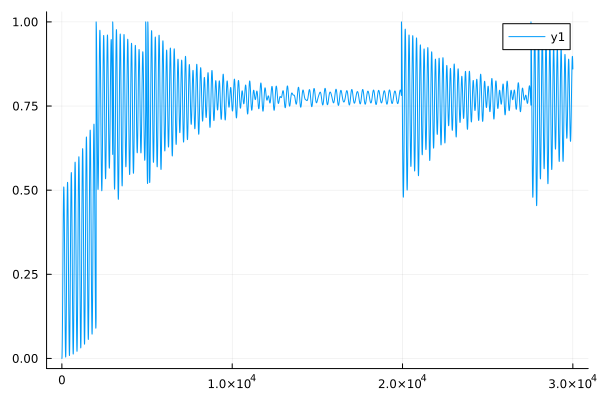

In [7]:
t_range = 1:dt:t_final
plot(v_exp)